In [560]:
import pandas as pd
import shapefile
import os
import matplotlib
import numpy as np
from scipy.stats import kstest, norm, expon, gamma, poisson, ks_2samp, uniform, triang, lognorm, pareto
from sklearn.linear_model import LinearRegression
import math
import matplotlib.pyplot as plt
NFDB_PATH = 'NFDB_point/NFDB_point_20240613.shp'

In [507]:
!python3 -m pip install scipy

In [508]:
#function from https://stackoverflow.com/questions/55112771/read-shapefiles-into-dataframe
def read_shapefile(shp_path):
	"""
	Read a shapefile into a Pandas dataframe with a 'coords' column holding
	the geometry information. This uses the pyshp package
	"""
	import shapefile

	#read file, parse out the records and shapes
	sf = shapefile.Reader(shp_path)
	fields = [x[0] for x in sf.fields][1:]
	records = sf.records()
	shps = [s.points for s in sf.shapes()]

	#write into a dataframe
	df = pd.DataFrame(columns=fields, data=records)
	df = df.assign(coords=shps)

	return df

In [509]:
data = read_shapefile(NFDB_PATH)

In [510]:
print(data.columns)

Index(['NFDBFIREID', 'SRC_AGENCY', 'NAT_PARK', 'FIRE_ID', 'FIRENAME',
       'LATITUDE', 'LONGITUDE', 'YEAR', 'MONTH', 'DAY', 'REP_DATE',
       'ATTK_DATE', 'OUT_DATE', 'SIZE_HA', 'CAUSE', 'CAUSE2', 'FIRE_TYPE',
       'RESPONSE', 'PROTZONE', 'PRESCRIBED', 'MORE_INFO', 'CFS_NOTE1',
       'CFS_NOTE2', 'ACQ_DATE', 'coords'],
      dtype='object')


In [511]:
non_null_count = data["OUT_DATE"].notnull().sum()
print(f"Count of non-null OUT_DATE entries: {non_null_count}")

Count of non-null OUT_DATE entries: 223048


/var/folders/y9/ffkjtgxj69s2tqfn7x4kpth00000gn/T/ipykernel_3903/3451890986.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["DURATION_DAYS"] = (filtered_data["OUT_DATE"] - filtered_data["ATTK_DATE"]).dt.days


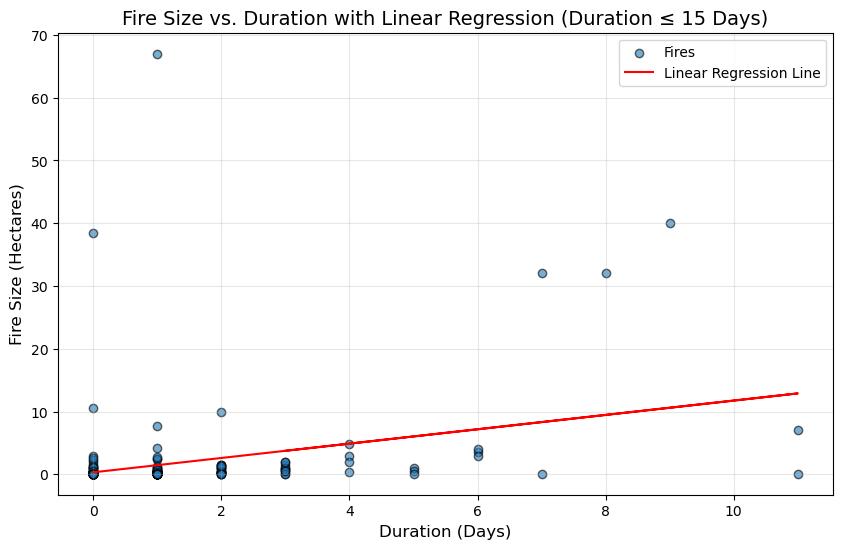

Intercept: 0.3232
Slope: 1.1429


In [557]:
#set dates to datetime, clean data 
data["OUT_DATE"] = pd.to_datetime(data["OUT_DATE"], errors="coerce")
data["ATTK_DATE"] = pd.to_datetime(data["ATTK_DATE"], errors="coerce")
filtered_data = data[data["OUT_DATE"].notnull()]

#determine duration of fires
filtered_data["DURATION_DAYS"] = (filtered_data["OUT_DATE"] - filtered_data["ATTK_DATE"]).dt.days

#filter out unreliable / outlier data
filtered_data = filtered_data[filtered_data["DURATION_DAYS"] <= 15]

#linear regression
X = filtered_data["DURATION_DAYS"].values.reshape(-1, 1)  
y = filtered_data["SIZE_HA"].values  
model = LinearRegression()
model.fit(X, y)

#linear prediction
y_pred = model.predict(X)

#plotting
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.6, edgecolor="black", label="Fires")
plt.plot(X, y_pred, color="red", label="Linear Regression Line")
plt.title("Fire Size vs. Duration with Linear Regression (Duration ≤ 15 Days)", fontsize=14)
plt.xlabel("Duration (Days)", fontsize=12)
plt.ylabel("Fire Size (Hectares)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()

#vals
print(f"Intercept: {model.intercept_:.4f}")
print(f"Slope: {model.coef_[0]:.4f}")


# Exploratory Analysis
All code below run nationwide; redo with BC data

In [514]:
test_decade = data[(data["YEAR"] >= 1992) & (data["YEAR"] <= 2022)]

In [515]:
test_decade_bc = test_decade[test_decade["SRC_AGENCY"] == "BC"]

In [516]:
decade_r_bc = test_decade_bc.drop(['coords', 'CFS_NOTE2', 'FIRENAME', 'NAT_PARK', 'LATITUDE', 'LONGITUDE', 'CFS_NOTE1', 'NFDBFIREID'], axis=1)

In [517]:
decade_r_bc.shape

(55529, 17)

In [518]:
decade_r_bc_filter = decade_r_bc[decade_r_bc["SIZE_HA"] > 2]

In [519]:
decade_r_bc_filter = decade_r_bc_filter[(decade_r_bc_filter["MONTH"] == 8)]

In [520]:
decade_r_bc_filter.shape

(1812, 17)

## Interarrival time analysis

In [521]:
x_h=0.6
x_l=0.35
iar_1 = decade_r_bc_filter
iar_1["REP_DATE"] = pd.to_datetime(iar_1["REP_DATE"])
iar_1 = iar_1.sort_values(by=["YEAR", "REP_DATE"])
iar_1["INTERARRIVAL"] = iar_1.groupby("YEAR")["REP_DATE"].diff().dt.days
mean_interarrival = iar_1.groupby("YEAR")["INTERARRIVAL"].mean()

mean_interarrival_all_years = iar_1["INTERARRIVAL"].mean()

#fixing iar_1 - removing years w mean interarrival > x
#filtering out years of outlier data - normalizing mean interarrivals
#other years were drastically different 
years_to_remove = mean_interarrival[(mean_interarrival < x_l) | (mean_interarrival > x_h)].index
iar_1 = iar_1[~iar_1["YEAR"].isin(years_to_remove)]
mean_interarrival = iar_1.groupby("YEAR")["INTERARRIVAL"].mean()
print(mean_interarrival)

print("Mean interarrival time across all years:", mean_interarrival_all_years)

YEAR
1992    0.351351
2000    0.410714
2004    0.360000
2010    0.543478
2012    0.453125
2013    0.405797
2014    0.433333
2015    0.471698
2017    0.509091
2021    0.519231
Name: INTERARRIVAL, dtype: float64
Mean interarrival time across all years: 0.4542391914654688


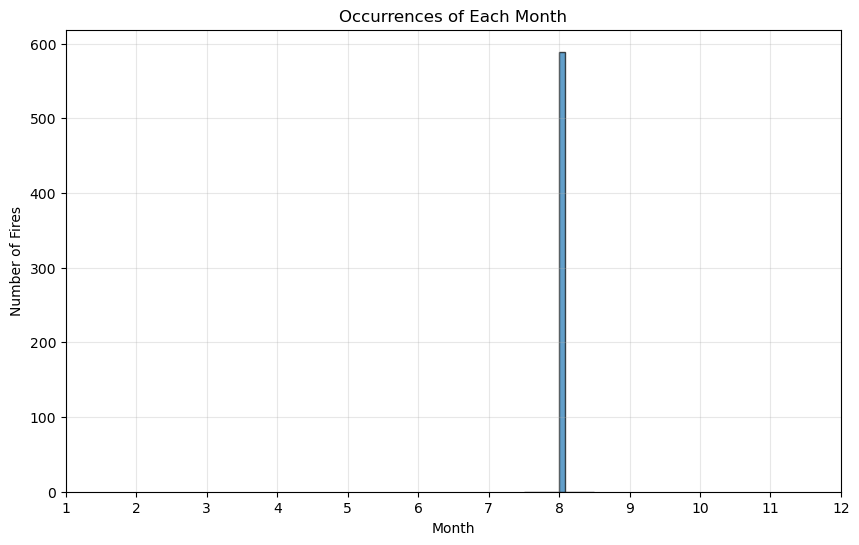

In [522]:
#for testing purposes when comparing monthly occurences
plt.figure(figsize=(10, 6))
plt.hist(iar_1['MONTH'], bins=12, edgecolor='black', alpha=0.7)
plt.title("Occurrences of Each Month")
plt.xlabel("Month")
plt.ylabel("Number of Fires")
plt.xticks(range(1, 13))  # Set x-axis labels to months 1-12
plt.grid(alpha=0.3)
plt.show()

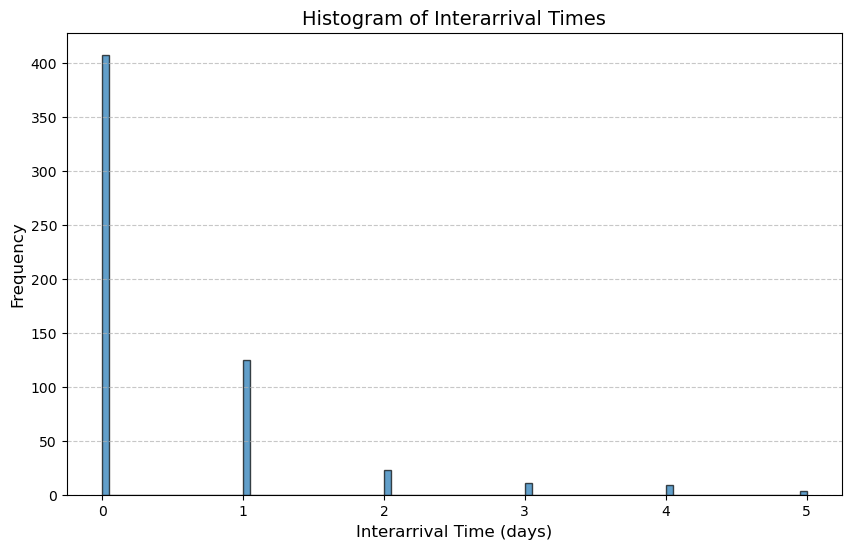

In [523]:
#fire intervals
interarrival_times = iar_1["INTERARRIVAL"].dropna()

plt.figure(figsize=(10, 6))
plt.hist(interarrival_times, bins=100, edgecolor="black", alpha=0.7)

plt.title("Histogram of Interarrival Times", fontsize=14)
plt.xlabel("Interarrival Time (days)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

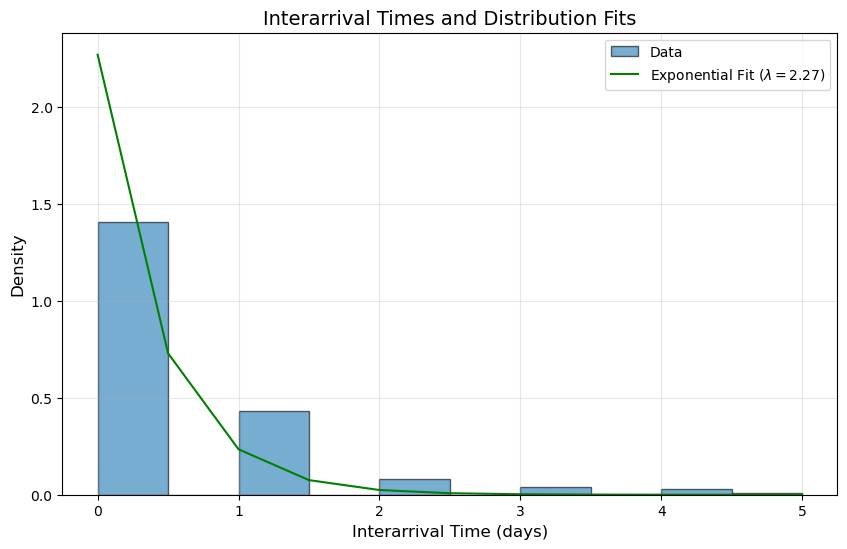

KS Statistic (D): 0.7047
P-value: 0.0000


In [524]:
#initial fitting - interarrival times to exponential distribution
#ineffective - interval times were discrete, could not fit directly to expo distribution

interarrival_times = iar_1["INTERARRIVAL"].dropna()

plt.figure(figsize=(10, 6))
counts, bins, _ = plt.hist(interarrival_times, bins=10, density=True, edgecolor="black", alpha=0.6, label="Data")

loc, scale = expon.fit(interarrival_times)
pdf_expon = expon.pdf(bins, loc, scale)
plt.plot(bins, pdf_expon, 'g-', label=f"Exponential Fit ($\lambda={1/scale:.2f}$)")

plt.title("Interarrival Times and Distribution Fits", fontsize=14)
plt.xlabel("Interarrival Time (days)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()

D, p_value = kstest(interarrival_times, 'expon', args=(loc, scale))

# Print the results
print(f"KS Statistic (D): {D:.4f}")
print(f"P-value: {p_value:.4f}")

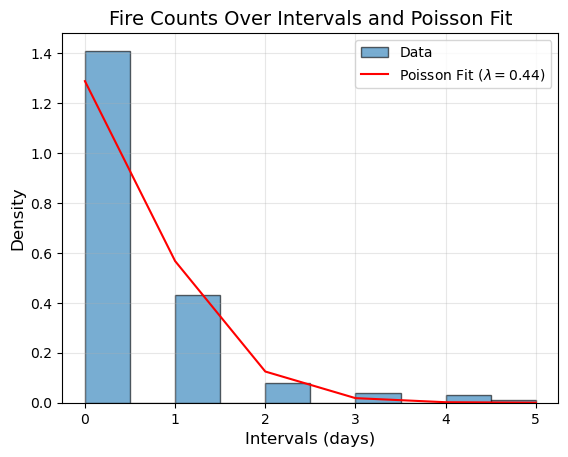

In [525]:
interarrival_times = iar_1["INTERARRIVAL"].dropna()

#mean fire counts / interval
lambda_poisson = interarrival_times.mean()
counts, bins, _ = plt.hist(interarrival_times, bins=10, density=True, edgecolor="black", alpha=0.6, label="Data")

#calculate poisson PMF
x_vals = np.arange(0, int(interarrival_times.max())+1)
pmf_poisson = poisson.pmf(x_vals, lambda_poisson)

#normalize
pmf_poisson_scaled = pmf_poisson / pmf_poisson.sum() * (counts.sum())

#plot poisson fit
plt.plot(x_vals, pmf_poisson_scaled, 'r-', label=f"Poisson Fit ($\lambda={lambda_poisson:.2f}$)")
plt.title("Fire Counts Over Intervals and Poisson Fit", fontsize=14)
plt.xlabel("Intervals (days)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()

In [558]:
#drop NaN - assuming none due to previous filtering
interarrival_times = iar_1["INTERARRIVAL"].dropna()

#means of interval counts
lambda_poisson = interarrival_times.mean()

#generate expected PMF
expected_pmf = poisson.pmf(np.arange(0, int(interarrival_times.max()) + 1), lambda_poisson)

#ks test
observed_counts = np.histogram(interarrival_times, bins=np.arange(0, int(interarrival_times.max()) + 2))[0]
observed_cdf = np.cumsum(observed_counts) / np.sum(observed_counts)
expected_cdf = np.cumsum(expected_pmf) / np.sum(expected_pmf)
D, p_value = ks_2samp(observed_cdf, expected_cdf)
print(f"KS Statistic (D): {D:.4f}")
print(f"P-value: {p_value:.4f}")



KS Statistic (D): 0.3333
P-value: 0.9307


### Now, modeling fire size

In [559]:
iar_1.tail()

,SRC_AGENCY,FIRE_ID,YEAR,MONTH,DAY,REP_DATE,ATTK_DATE,OUT_DATE,SIZE_HA,CAUSE,CAUSE2,FIRE_TYPE,RESPONSE,PROTZONE,PRESCRIBED,MORE_INFO,ACQ_DATE,INTERARRIVAL,CLASS
158973,BC,2021-V62669,2021,8,19,2021-08-19,NaT,NaT,61.50,H,H,Fire,,,,,2022-04-11,2.0,"(41.5, 26399.0]"
159544,BC,2021-G12683,2021,8,19,2021-08-19,NaT,NaT,70.25,N,N,Fire,,,,,2022-04-11,0.0,"(41.5, 26399.0]"
159408,BC,2021-K52716,2021,8,24,2021-08-24,NaT,NaT,2.67,H,H,Fire,,,,,2022-04-11,5.0,"(2.099, 5.5]"
159342,BC,2021-G72730,2021,8,25,2021-08-25,NaT,NaT,4.48,N,N,Fire,,,,,2022-04-11,1.0,"(2.099, 5.5]"
159131,BC,2021-K52739,2021,8,28,2021-08-28,NaT,NaT,227.00,H,H,Fire,,,,,2022-04-11,3.0,"(41.5, 26399.0]"


In [528]:
unique_years = iar_1["YEAR"].unique()
print(unique_years)

[1992 2000 2004 2010 2012 2013 2014 2015 2017 2021]


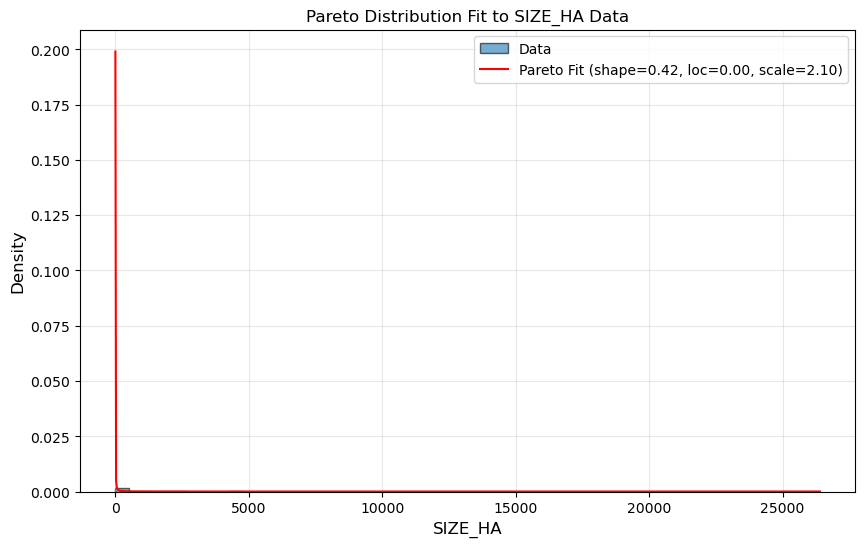

KS Statistic (D): 0.06791171477079797
P-value: 0.13220715349994624


In [555]:
##### Fitting Fire Size Distribution
#filter out invalid
size_data = iar_1['SIZE_HA'].dropna()
#ensure positive values - there should already be none as ['SIZE_HA'] limited to > 2 Ha
size_data = size_data[size_data > 0]  

#fit to pareto distribution using scipy
shape, loc, scale = pareto.fit(size_data, floc=0)

#generate pareto values according to fit estimates
x = np.linspace(size_data.min(), size_data.max(), 1000)
pdf_pareto = pareto.pdf(x, shape, loc, scale)

#plot
plt.figure(figsize=(10, 6))
plt.hist(size_data, bins=50, density=True, alpha=0.6, edgecolor="black", label="Data")
plt.plot(x, pdf_pareto, 'r-', label=f"Pareto Fit (shape={shape:.2f}, loc={loc:.2f}, scale={scale:.2f})")
plt.title("Pareto Distribution Fit to SIZE_HA Data")
plt.xlabel("SIZE_HA", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()

#KS test
D, p_value = ks_2samp(size_data, pareto.rvs(shape, loc, scale, size=len(size_data)))

print(f"KS Statistic (D): {D}")
print(f"P-value: {p_value}")
